## In this task, we will try to predict if a patient has Sepsis 

In [1]:
import pandas as pd



import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import seaborn as sns   
import matplotlib.pyplot as plt

train_features = pd.read_csv("../extract_new_feature/train_new_features.csv").sort_values(by='pid')
#test = pd.read_csv("extract_new_feature/test_imputed.csv").sort_values(by='pid')
train_labels = pd.read_csv("../../train_labels.csv").sort_values(by='pid')
#data = pd.concat([train_features, train_labels], axis=1, sort=False)

/home/aizardar/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


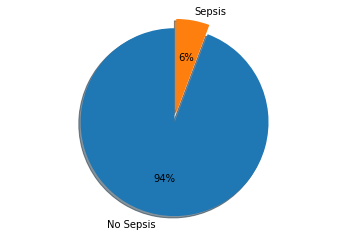

In [3]:
# Let's see the percentage of people suffering from Sepsis

df = train_labels['LABEL_Sepsis'].value_counts()
No_sepsis_percent = (df[0]/(df[0]+df[1]))*100
sepsis_percent = (df[1]/(df[0]+df[1]))*100

labels = 'No Sepsis', 'Sepsis'
sizes = [No_sepsis_percent, sepsis_percent]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode = explode, labels = labels, autopct = '%1.0f%%', shadow=True, startangle = 90)
ax1.axis('equal')
plt.show()


### 94% Patients are not suffering from Sepsis. This shows that we are dealing with highly imbalanced data here 

## We will use all features

LABEL_Sepsis
Mean Cross-validated AUC score (RF)=  0.6926164046317902
Mean Cross-validated AUC score (SVC)=  0.6680005446236763
Mean Cross-validated AUC score (GB)=  0.715901750790279
-----------------------------------------------------


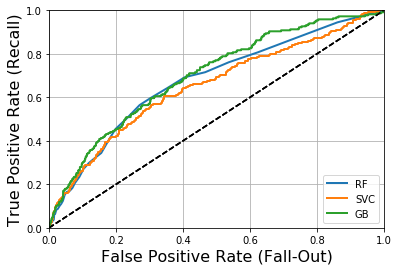

AUC (RF) =  0.6759502880903033
AUC (SVC) =  0.6504769053798205
AUC (GB) =  0.6990160864296531
---------------------------------------------------------------


In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn import metrics


# Let's define a function to plot a ROC curve


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True) 
    


TESTS = ['LABEL_Sepsis']

auc_values_val_rf = []
auc_values_val_svc = []
auc_values_val_gb = []

for label in TESTS:
    
    print(label)
    
    X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels[label], test_size=0.2, random_state=2020, stratify = train_labels[label])

    # Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns = train_features.columns)
    X_val_scaled = scaler.transform(X_val)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns = train_features.columns)


    feature_cols = X_train.columns.values[(X_train.columns.values != 'pid') & (X_train.columns.values != 'Time')]

    X_train = X_train[feature_cols]
    X_val = X_val[feature_cols]
    
    feature_cols_scaled = X_train_scaled.columns.values[(X_train_scaled.columns.values != 'pid') & (X_train_scaled.columns.values != 'Time')]

    X_train_scaled = X_train_scaled[feature_cols]
    X_val_scaled = X_val_scaled[feature_cols]
    
    
    
    
    forest_clf = RandomForestClassifier(random_state=42)
    svc = SVC(kernel = 'rbf', random_state=42, probability=True)
    gb = GradientBoostingClassifier(random_state = 42)
    
    
    skf = StratifiedKFold(n_splits=5)
    auc_scores_rf = cross_val_score(forest_clf, X_train, y_train, scoring = 'roc_auc', cv = skf, n_jobs = -1)
    auc_scores_svc = cross_val_score(svc, X_train_scaled, y_train, scoring = 'roc_auc', cv = skf, n_jobs = -1)
    auc_scores_gb = cross_val_score(gb, X_train, y_train, scoring = 'roc_auc', cv = skf, n_jobs = -1)

    
#    print("AUC scores = ", auc_scores)
    print("Mean Cross-validated AUC score (RF)= ", np.mean(auc_scores_rf))
    print("Mean Cross-validated AUC score (SVC)= ", np.mean(auc_scores_svc))
    print("Mean Cross-validated AUC score (GB)= ", np.mean(auc_scores_gb))
    print("-----------------------------------------------------")
    
    # Let's check models performance on Validation set 
    
    forest_clf.fit(X_train, y_train)
    svc.fit(X_train_scaled, y_train)
    gb.fit(X_train,y_train)
    
    predictions_prob_val_rf = forest_clf.predict_proba(X_val)
    predictions_prob_val_svc = svc.predict_proba(X_val_scaled)
    predictions_prob_val_gb = gb.predict_proba(X_val)

    
    predict_prob_val_rf = np.ravel(predictions_prob_val_rf[:,1])
    predict_prob_val_svc = np.ravel(predictions_prob_val_svc[:,1])
    predict_prob_val_gb = np.ravel(predictions_prob_val_gb[:,1])

    
    
    fpr, tpr, thresholds_rf = roc_curve(y_val,predict_prob_val_rf)
    fpc, tpc, thresholds_svc = roc_curve(y_val,predict_prob_val_svc)
    fpgb, tpgb, thresholds_gb = roc_curve(y_val,predict_prob_val_gb)
    
        
        
    plot_roc_curve(fpr, tpr, "RF")
    plot_roc_curve(fpc, tpc, "SVC")
    plot_roc_curve(fpgb, tpgb, "GB")

    
    
    
    plt.legend(loc="lower right")
    plt.show()

    auc_val_rf = metrics.roc_auc_score(y_val, predict_prob_val_rf)
    auc_val_svc = metrics.roc_auc_score(y_val, predict_prob_val_svc)
    auc_val_gb = metrics.roc_auc_score(y_val, predict_prob_val_gb)

    
    
    print("AUC (RF) = ", auc_val_rf)
    print("AUC (SVC) = ", auc_val_svc)
    print("AUC (GB) = ", auc_val_gb)

    
    
    auc_values_val_rf.append((auc_val_rf))
    auc_values_val_svc.append((auc_val_svc))
    print("---------------------------------------------------------------")


## Let's fine tune our RandomForestClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn import metrics


auc_values_val_rf = []

TESTS = ['LABEL_Sepsis']


for label in TESTS:
    
    print(label)
    
    X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels[label], test_size=0.2, random_state=2020, stratify = train_labels[label])

    feature_cols = X_train.columns.values[(X_train.columns.values != 'pid') & (X_train.columns.values != 'Time')]

    X_train = X_train[feature_cols]
    X_val = X_val[feature_cols]
    
    
    forest_clf = RandomForestClassifier(random_state=42)
    skf = StratifiedKFold(n_splits=5)
    
    param_grid = { 
    'n_estimators': [400,800],
    'max_features': ['auto', 'log2'],
    'criterion' :['gini','entropy']}    
    
    CV_rf = GridSearchCV(estimator=forest_clf, param_grid=param_grid, cv = skf, scoring = 'roc_auc', n_jobs = -1)
    
    CV_rf.fit(X_train, y_train)
    forest_clf.fit(X_train, y_train)
    
    #Without fine tuning 
    
    predictions_prob_val = forest_clf.predict_proba(X_val)
    
    predict_prob_val = np.ravel(predictions_prob_val[:,1])
  
    auc_val = metrics.roc_auc_score(y_val, predict_prob_val)
    
    print("AUC (Without fine tuning) = ", auc_val)
    
    # With fine tuning 
    
    print("Best parameters after Grid Search CV")
        
    print(CV_rf.best_params_)                  
    
    predictions_prob_val_rf = CV_rf.predict_proba(X_val)
    
    predict_prob_val_rf = np.ravel(predictions_prob_val_rf[:,1])
  
    auc_val_rf = metrics.roc_auc_score(y_val, predict_prob_val_rf)
    
    print("AUC with best parameters = ", auc_val_rf)
    
    auc_values_val_rf.append((auc_val_rf))
    print("---------------------------------------------------------------")

### Which features contribute the most ?

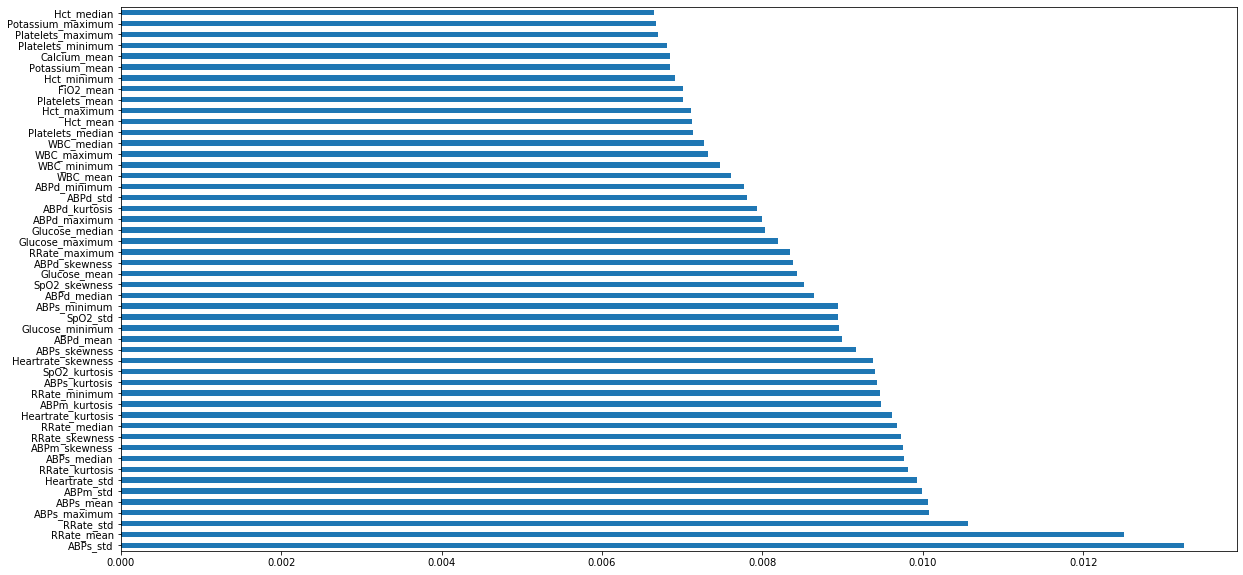

In [5]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
plt.figure(figsize=(20,10))

from sklearn.svm import SVC

feature_cols = train_features.columns.values[(train_features.columns.values != 'pid') & (train_features.columns.values != 'Time')]

X_train = train_features[feature_cols]


model = RandomForestClassifier(n_estimators=400,criterion = 'entropy', max_features = 'log2',random_state=1211)
model.fit(X_train,train_labels['LABEL_Sepsis'])
estimator = model.estimators_[5]
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(50).plot(kind='barh')
plt.show()